In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from typing import Callable, List, Tuple

from data.flood_event_1d2d_dataset import FloodEvent1D2DDataset
from utils import file_utils, plot_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Visualization

In [11]:
config_path = 'configs/config_1d2d_model1.yaml'
config = file_utils.read_yaml_file(config_path)

In [ ]:
mode = 'train' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
previous_timesteps = dataset_parameters['previous_timesteps']
dataset = FloodEvent1D2DDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_2d_shp_file=dataset_parameters['nodes_2d_shp_file'],
    edges_2d_shp_file=dataset_parameters['edges_2d_shp_file'],
    nodes_1d_shp_file=dataset_parameters['nodes_1d_shp_file'],
    edges_1d_shp_file=dataset_parameters['edges_1d_shp_file'],
    edges_1d2d_shp_file=dataset_parameters['edges_1d2d_shp_file'],
    dem_file=dataset_parameters['dem_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
    save=False,
    perimeter_name=dataset_parameters['perimeter_name'],
)

HecRas Files: ['HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p22.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p23.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p24.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p25.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p26.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p27.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p28.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p29.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p30.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p31.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p32.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p33.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p34.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p35.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p36.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p37.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p38.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p39.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p40.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p41.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p42.hdf'

In [13]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 78
Total number of timesteps: 20406


In [14]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
tick_interval_in_hours = 12

In [15]:
def plot_timeseries_per_event(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    aggregation_func: Callable = None,
    mask: np.ndarray = None,
):
    longest_hours_elapsed = []
    for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_paths):
        data = np.load(path)[data_key][previous_timesteps:]
        feature_data = data[start_ts:end_ts, :, feature_idx]

        if mask is not None:
            # print(f'Applying mask: {mask}')
            feature_data = feature_data[:, mask]

        feature_data = dataset.normalizer.denormalize(feature_name, feature_data)

        if aggregation_func is not None:
            feature_data = aggregation_func(feature_data)

        # Plot
        hours_elapsed = np.arange(len(feature_data)) * delta_t_in_hours
        plt.plot(hours_elapsed, feature_data, label=f'Run {run_id}')

        if len(hours_elapsed) > len(longest_hours_elapsed):
            longest_hours_elapsed = hours_elapsed

    # Configure plot
    plt.title(title)
    plt.xlabel('Time (h)')
    interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
    plt.xticks(longest_hours_elapsed[interval_ticks])
    plt.ylabel(ylabel)
    plt.show()

# Plot 2D Node Features

### Note: In order to plot, you have to normalize the values to get the feature stats yaml file

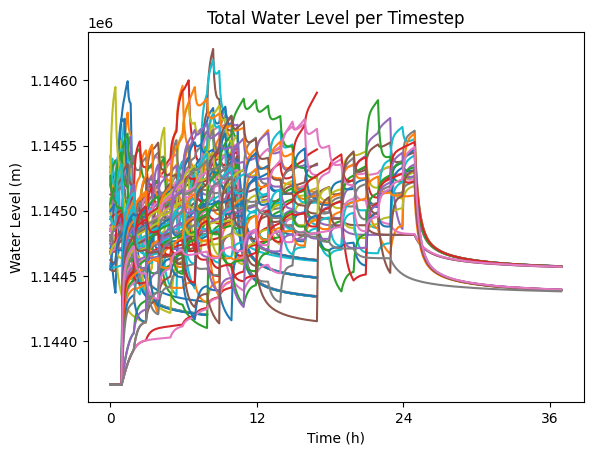

In [16]:
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]
node_data_key = 'dynamic_nodes'
water_volume_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='water_level',
    feature_idx=water_volume_idx,
    ylabel='Water Level (m)',
    title='Total Water Level per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

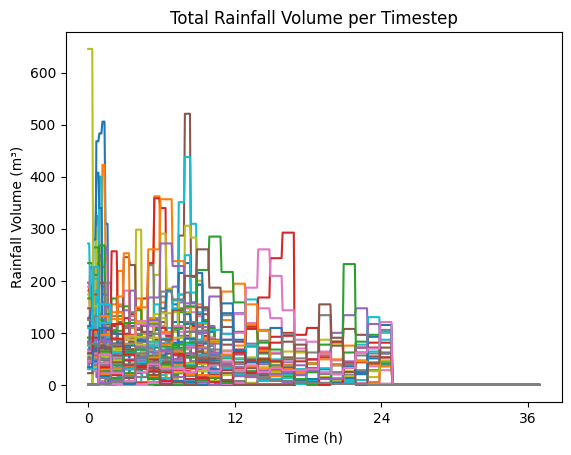

In [17]:
rainfall_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('rainfall')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='rainfall',
    feature_idx=rainfall_idx,
    ylabel='Rainfall Volume (m³)',
    title='Total Rainfall Volume per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

# Plot 1D Dynamic Node Features

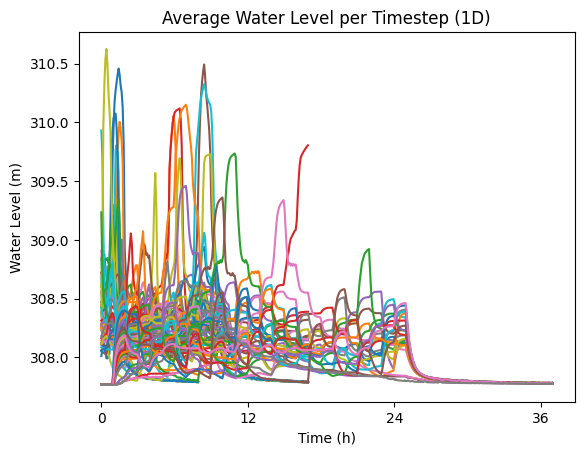

In [18]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='water_level',
    feature_idx=water_level_idx,
    ylabel='Water Level (m)',
    title='Average Water Level per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

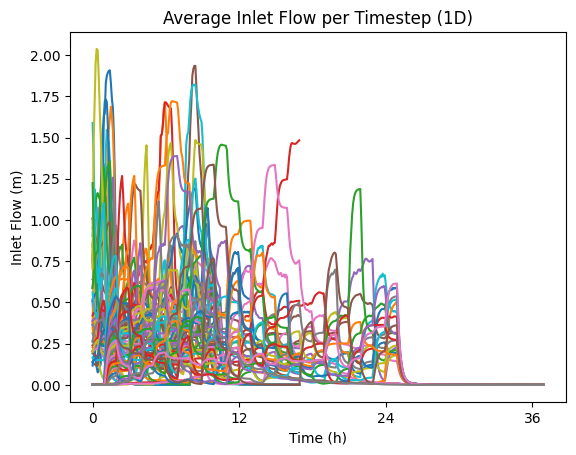

In [19]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('inlet_flow')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='inlet_flow',
    feature_idx=water_level_idx,
    ylabel='Inlet Flow (m)',
    title='Average Inlet Flow per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

# Plot 2D Dynamic Edge Features

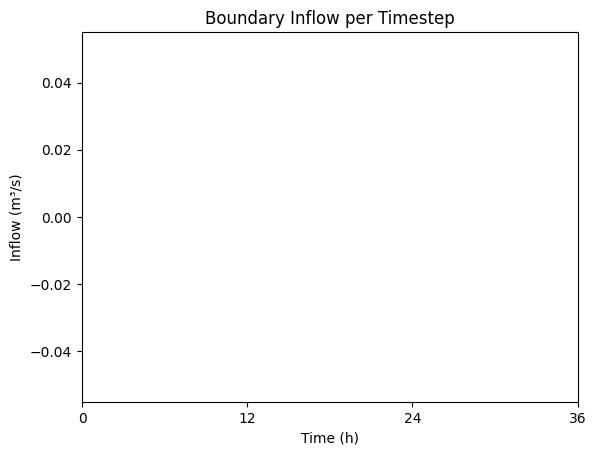

In [22]:
# Plot total inflow per timestep
dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]
edge_data_key = 'dynamic_edges'
flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index('flow')
inflow_edge_mask = dataset.boundary_condition.inflow_edges_mask

plot_timeseries_per_event(
    dynamic_paths=dynamic_edges_paths,
    data_key=edge_data_key,
    feature_name='flow',
    feature_idx=flow_idx,
    ylabel='Inflow (m³/s)',
    title='Boundary Inflow per Timestep',
    mask=inflow_edge_mask,
)

In [23]:
event_end_idx = [*dataset.event_start_idx, dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 21 - Event Size: 95 timesteps
Run 22 - Event Size: 95 timesteps
Run 23 - Event Size: 95 timesteps
Run 24 - Event Size: 95 timesteps
Run 25 - Event Size: 95 timesteps
Run 26 - Event Size: 95 timesteps
Run 27 - Event Size: 95 timesteps
Run 28 - Event Size: 95 timesteps
Run 29 - Event Size: 95 timesteps
Run 30 - Event Size: 95 timesteps
Run 31 - Event Size: 95 timesteps
Run 32 - Event Size: 203 timesteps
Run 33 - Event Size: 203 timesteps
Run 34 - Event Size: 203 timesteps
Run 35 - Event Size: 203 timesteps
Run 36 - Event Size: 203 timesteps
Run 37 - Event Size: 203 timesteps
Run 38 - Event Size: 203 timesteps
Run 39 - Event Size: 203 timesteps
Run 40 - Event Size: 203 timesteps
Run 41 - Event Size: 203 timesteps
Run 42 - Event Size: 203 timesteps
Run 43 - Event Size: 203 timesteps
Run 44 - Event Size: 203 timesteps
Run 45 - Event Size: 203 timesteps
Run 46 - Event Size: 203 timesteps
Run 47 - Event Size: 203 timesteps
Run 48 - Event Size: 203 timesteps
Run 49 - Event Size: 203 timest

Nodes with the highest water volume difference:
Node 3241: 211.38 m
Node 3240: 195.27 m
Node 3132: 193.89 m
Node 3131: 193.32 m
Node 3133: 139.91 m
Reading HDF file: data/Model1/raw/HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p22.hdf
Init inflow boundary nodes:  None
Init outflow boundary nodes:  [3741, 3742, 3745, 3748, 3749, 3751, 3756, 3757, 3761, 3762, 3763, 3764]


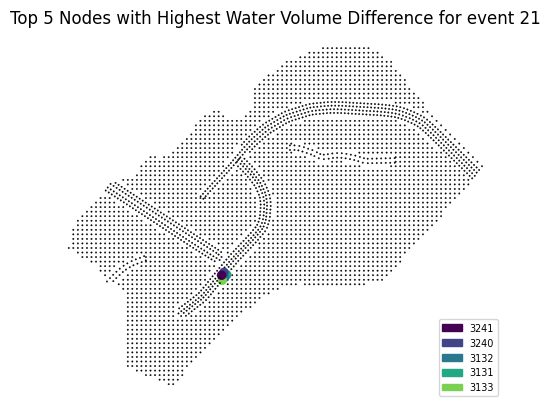

In [24]:
def get_highest_diff_entities(dynamic_path: str,
                              data_key: str,
                              feature_name: str,
                              feature_idx: int,
                              k: int = 4) -> Tuple[List, np.ndarray]:
    data = np.load(dynamic_path)[data_key]
    feature_data = data[:, :, feature_idx]
    feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
    feature_diff = np.abs(np.diff(feature_data, axis=0))
    feature_diff_per_entity = feature_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(feature_diff_per_entity)[-k:][::-1].tolist()
    top_k_wd_diff = feature_diff_per_entity[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff


EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top nodes to retrieve

event_dynamic_nodes_path = dynamic_nodes_paths[EVENT_IDX]
top_k_wv_diff_idx, top_k_wv_diff = get_highest_diff_entities(dynamic_path=event_dynamic_nodes_path,
                                                             data_key=node_data_key,
                                                             feature_name='water_volume',
                                                             feature_idx=water_volume_idx,
                                                             k=k)
print('Nodes with the highest water volume difference:')
for idx, wv in zip(top_k_wv_diff_idx, top_k_wv_diff):
    print(f"Node {idx}: {wv:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
node_df = plot_utils.get_node_df(config, run_id, mode=mode, no_ghost=True)
plot_utils.plot_cell_map_w_highlight(gpdf=node_df,
                                     title=f'Top {k} Nodes with Highest Water Volume Difference for event {run_id}',
                                     highlight_idxs=top_k_wv_diff_idx)

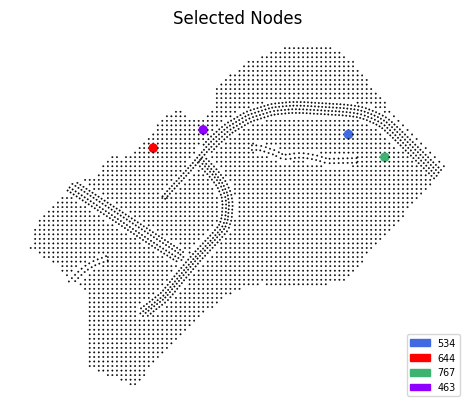

In [25]:
highlight_node_idx = [534, 644, 767, 463]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(node_df,
                                    title='Selected Nodes',
                                    highlight_idxs=highlight_node_idx,
                                    color_list=color_list,
                                    legend=False)

Edges with the highest water flow difference:
Edge 3148: 644.49 m
Edge 1052: 566.17 m
Edge 3327: 524.77 m
Edge 478: 523.13 m
Edge 1012: 505.85 m
Reading HDF file: data/Model1/raw/HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p22.hdf
Init inflow boundary nodes:  None
Init outflow boundary nodes:  [3741, 3742, 3745, 3748, 3749, 3751, 3756, 3757, 3761, 3762, 3763, 3764]


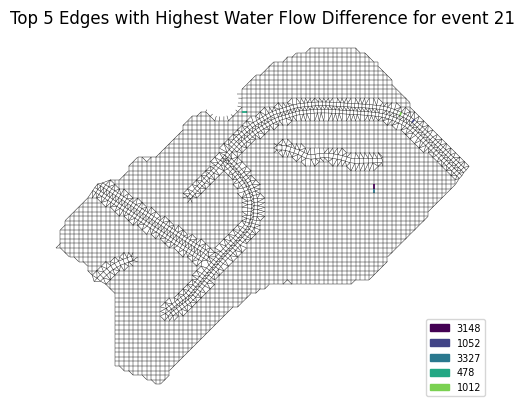

In [27]:
def get_highest_diff_water_flow_edges(dataset: FloodEvent1D2DDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_edges = np.load(dynamic_edges_paths[event_idx])['dynamic_edges']
    water_flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE)
    water_flow = dynamic_edges[:, :, water_flow_idx]
    water_flow = dataset.normalizer.denormalize(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE, water_flow)
    wf_diff = np.abs(np.diff(water_flow, axis=0))
    wf_diff_per_edge = wf_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wf_diff_per_edge)[-k:][::-1].tolist()
    top_k_wf_diff = wf_diff_per_edge[top_k_diff_idx]
    return top_k_diff_idx, top_k_wf_diff

# def get_edge_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
#     edges_shp_path = dataset.raw_paths[1]
#     link_df = gpd.read_file(edges_shp_path)

#     if no_ghost:
#         bc = dataset.boundary_condition
#         inflow_boundary_nodes = dataset.inflow_boundary_nodes
#         outflow_boundary_nodes = dataset.outflow_boundary_nodes
#         is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
#         boundary_nodes = np.concat([np.array(dataset.inflow_boundary_nodes), np.array(dataset.outflow_boundary_nodes)])
#         is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
#         link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

#         assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
#         assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

#     return link_df

EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top edges to retrieve

event_dynamic_edges_path = dynamic_edges_paths[EVENT_IDX]
top_k_wf_diff_idx, top_k_wf_diff = get_highest_diff_entities(dynamic_path=event_dynamic_edges_path,
                                                             data_key=edge_data_key,
                                                             feature_name='flow',
                                                             feature_idx=flow_idx,
                                                             k=k)
print('Edges with the highest water flow difference:')
for idx, wf in zip(top_k_wf_diff_idx, top_k_wf_diff):
    print(f"Edge {idx}: {wf:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
edge_df = plot_utils.get_edge_df(config, run_id, mode=mode, no_ghost=True)
plot_utils.plot_cell_map_w_highlight(gpdf=edge_df,
                                     title=f'Top {k} Edges with Highest Water Flow Difference for event {run_id}',
                                     highlight_idxs=top_k_wf_diff_idx)

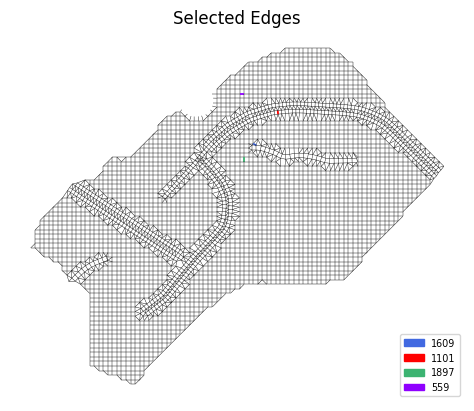

In [28]:
highlight_edge_idx = [1609, 1101, 1897, 559]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(edge_df,
                                     title='Selected Edges',
                                     highlight_idxs=highlight_edge_idx,
                                     color_list=color_list,
                                     legend=True)

In [29]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 609.3919
	Std: 116.1106
	Min: -0.0000
	Max: 1218.5624
aspect
	Mean: 184.8906
	Std: 115.0799
	Min: -1.0000
	Max: 359.9294
curvature
	Mean: 0.0001
	Std: 0.0003
	Min: 0.0000
	Max: 0.0052
elevation
	Mean: 323.1608
	Std: 14.4956
	Min: 293.8125
	Max: 360.2188
face_length
	Mean: 25.1484
	Std: 4.2164
	Min: 0.0000
	Max: 51.4703
flow
	Mean: 1.8536
	Std: 3.7042
	Min: -0.1254
	Max: 45.4464
flow_accumulation
	Mean: 1.5137
	Std: 1.4074
	Min: 1.0000
	Max: 31.0000
inlet_flow
	Mean: 0.2116
	Std: 0.5935
	Min: -0.0000
	Max: 9.4828
length
	Mean: 101.9903
	Std: 63.3068
	Min: 12.8575
	Max: 237.4081
position_x
	Mean: 802415.8750
	Std: 134.0707
	Min: 802092.3125
	Max: 802565.3750
position_y
	Mean: 349504.5938
	Std: 297.9814
	Min: 349133.1875
	Max: 350028.9062
rainfall
	Mean: 0.0111
	Std: 0.0156
	Min: 0.0000
	Max: 0.3473
relative_position_x
	Mean: -5.1993
	Std: 17.0455
	Min: -50.0000
	Max: 43.3750
relative_position_y
	Mean: 9.5210
	Std: 15.5559
	Min: -44.9062
	Max: 48.5938
rough

# Plot 2D Static Node & Edge Features

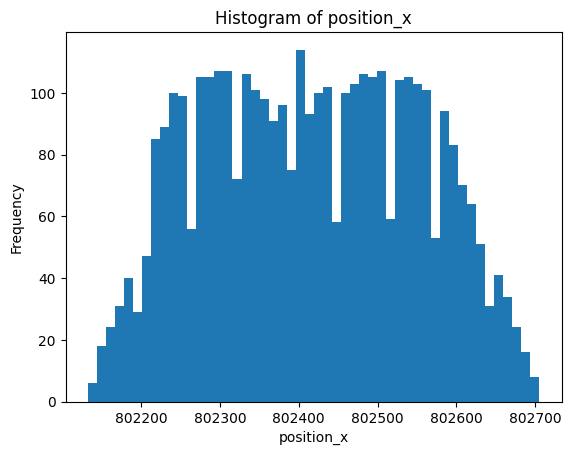

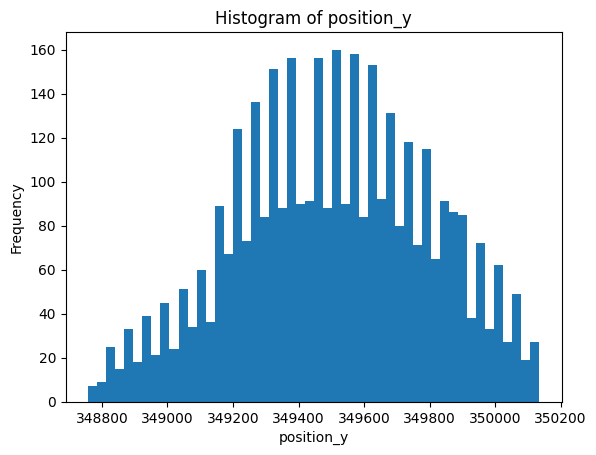

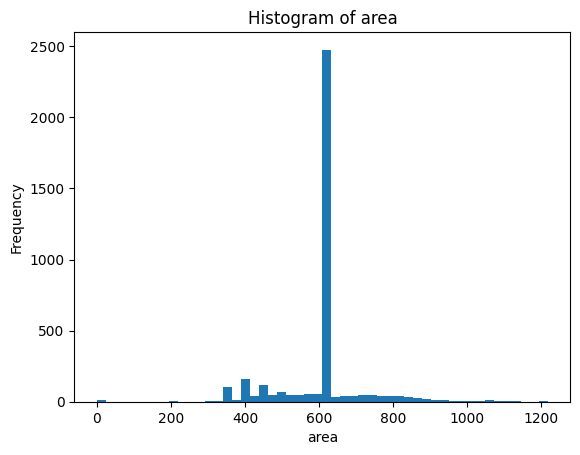

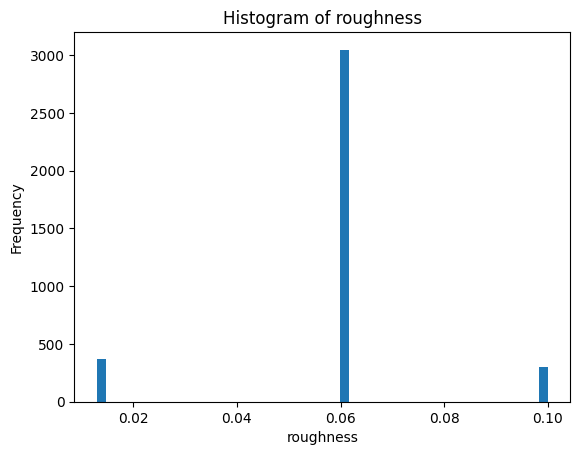

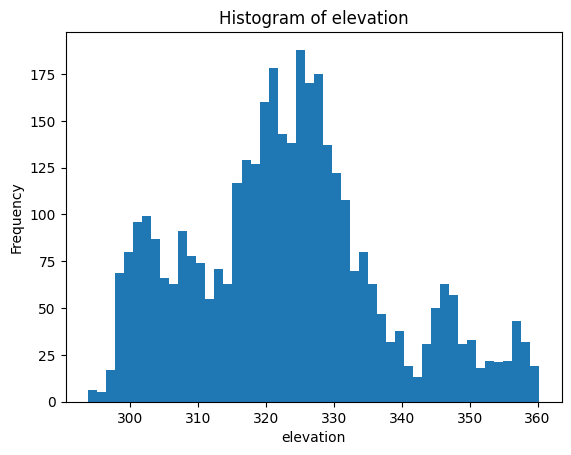

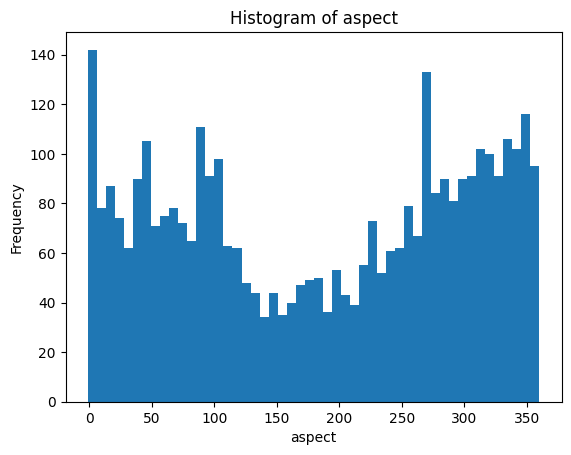

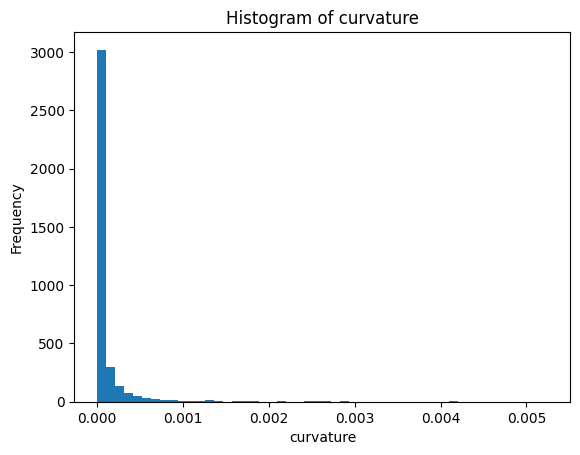

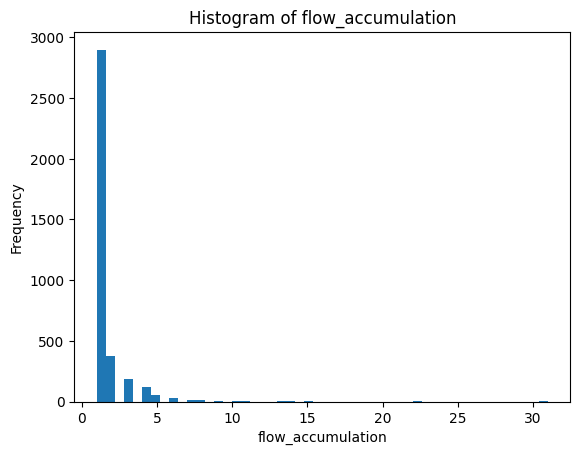

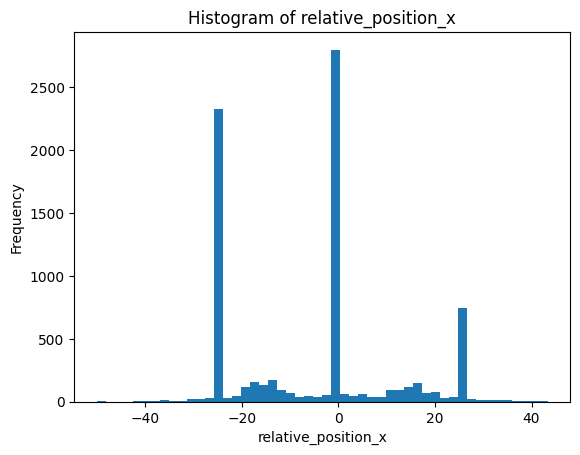

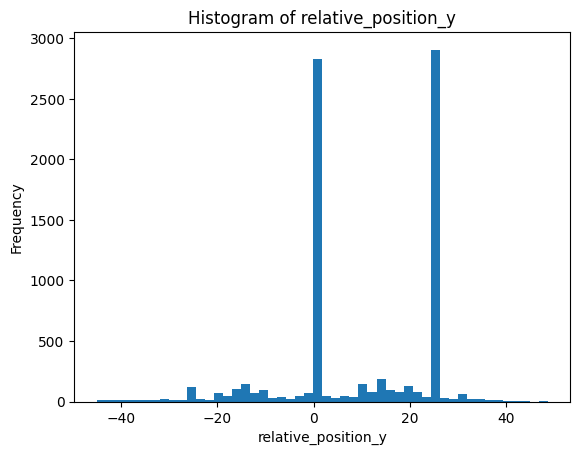

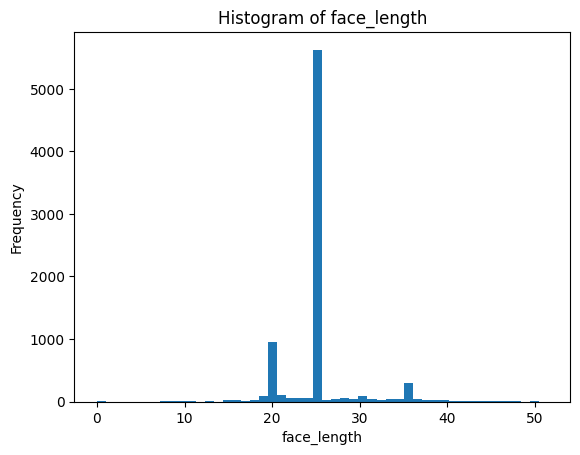

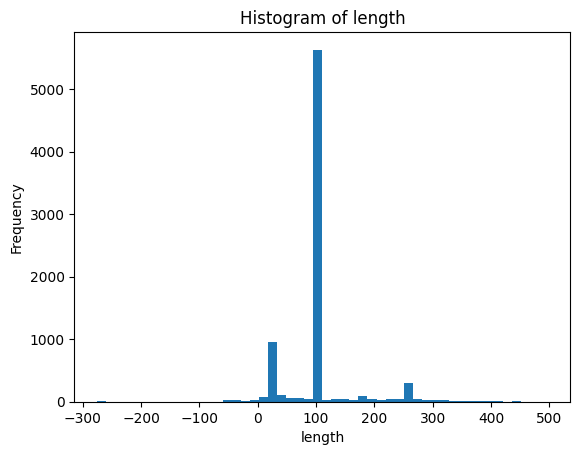

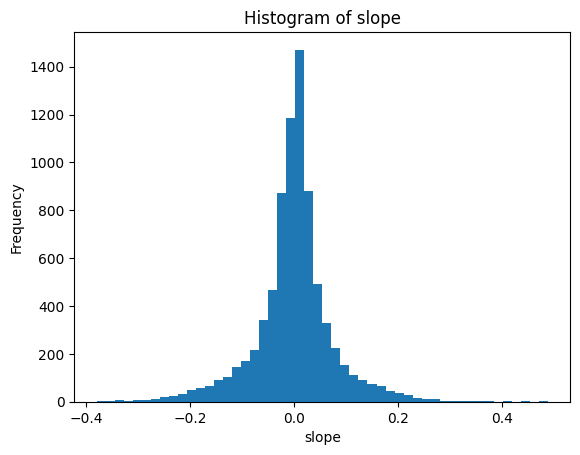

In [30]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 2D Dynamic Node & Edge Features

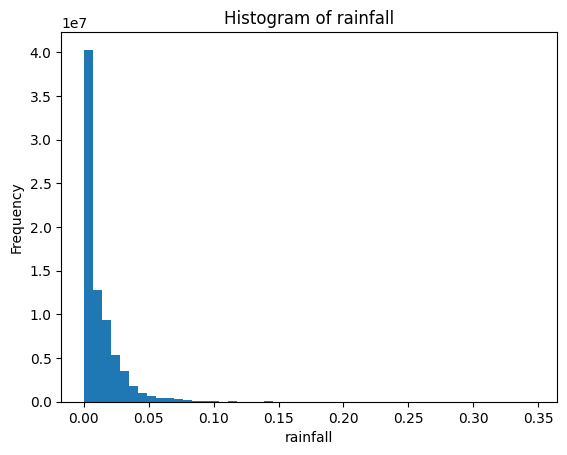

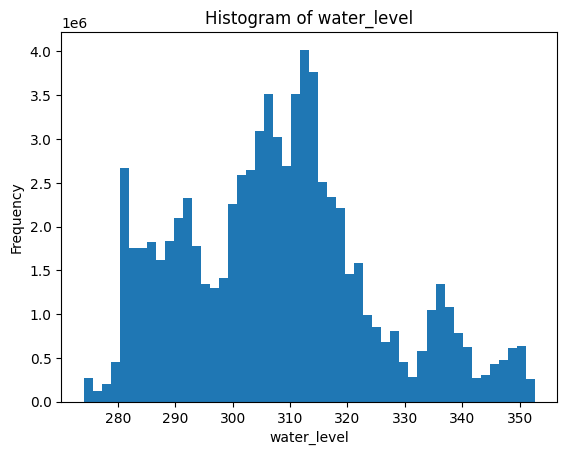

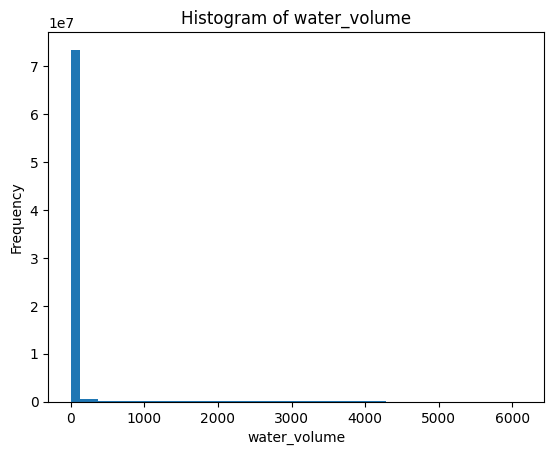

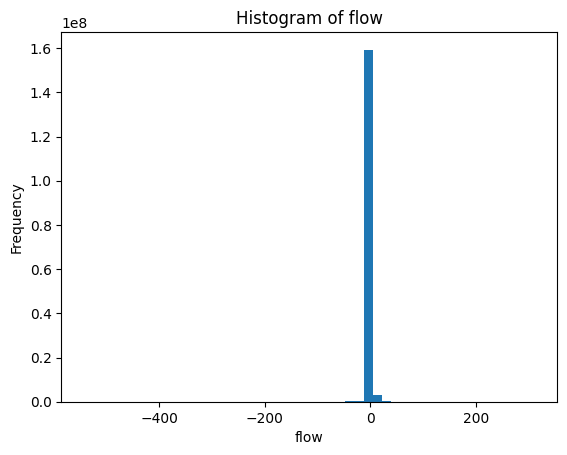

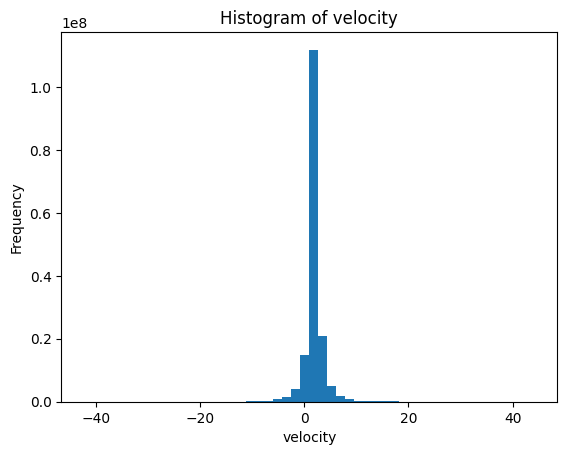

In [31]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


# Plot 1D Static Node & Edge Features

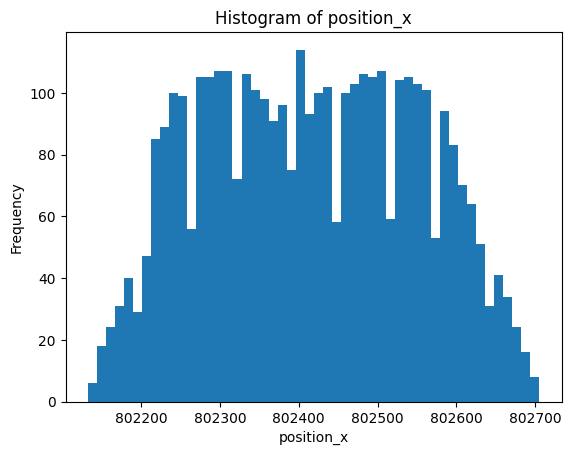

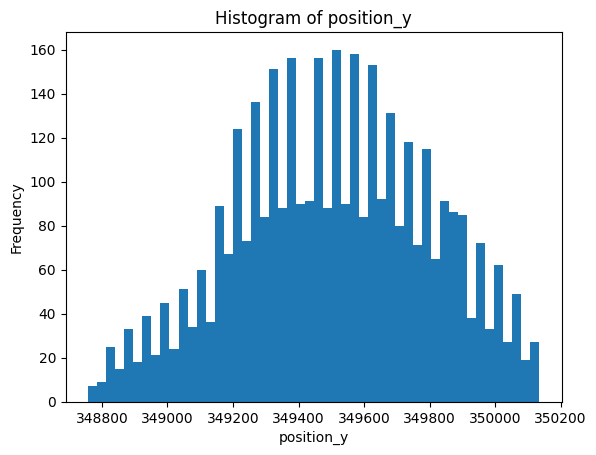

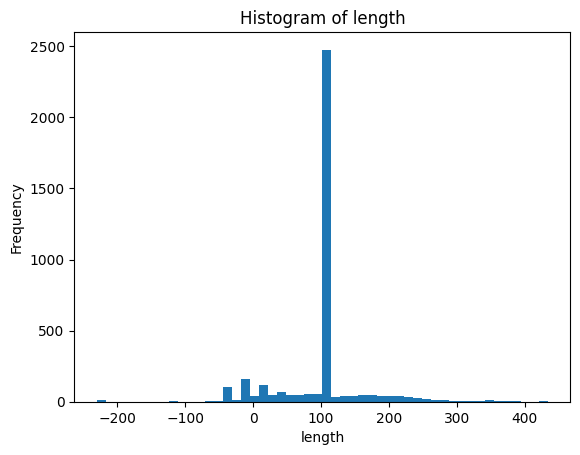

In [32]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 1D Dynamic Node & Edge Features

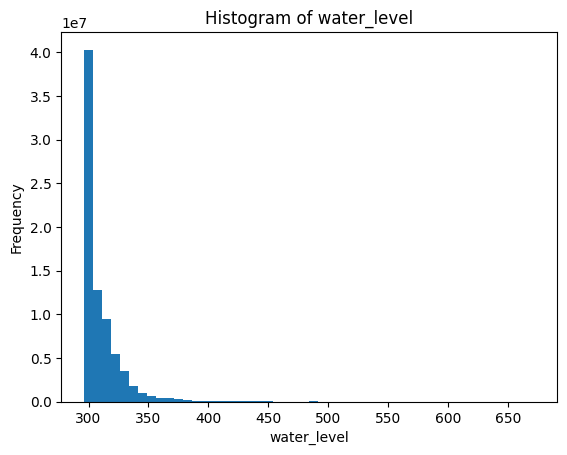

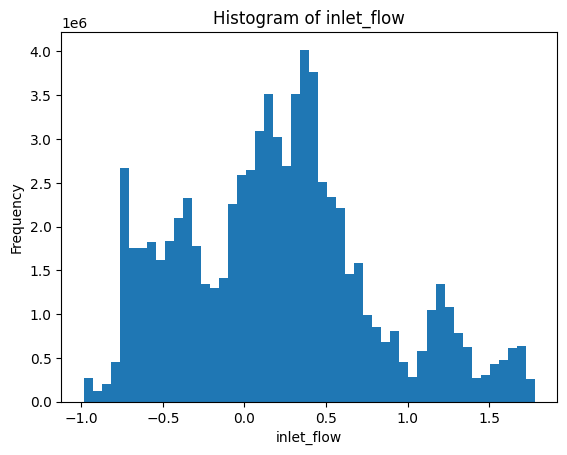

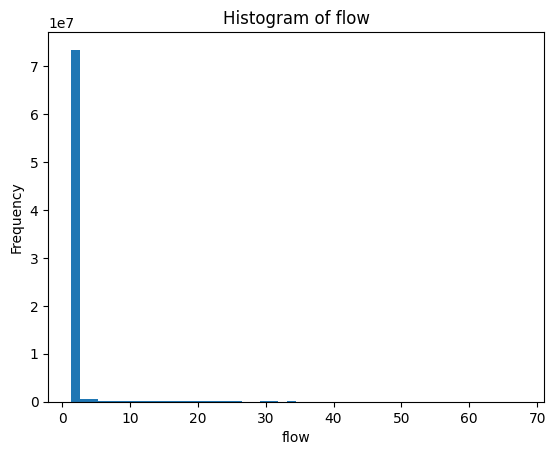

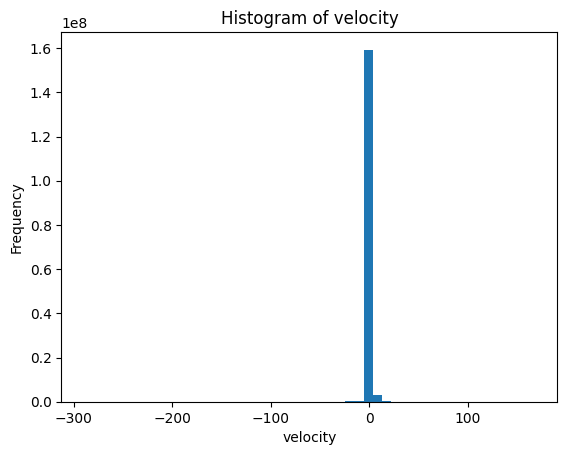

In [33]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
